pillcam dataset split into neg/pos and trained using resnet.py witouth augmentation or ds normalization.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
import matplotlib.pyplot as plt
import resnet

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import os
import pathlib

%matplotlib inline

In [2]:
NUM_GPUS = 1
BS_PER_GPU = 128
BATCH_SIZE = 128
NUM_EPOCHS = 10

IMG_HEIGHT = 64
IMG_WIDTH = 64
NUM_CHANNELS = 3
#NUM_TRAIN_SAMPLES = 40000

BASE_LEARNING_RATE = 0.1
LR_SCHEDULE = [(0.1, 30), (0.01, 45)]

In [16]:
data_dir = pathlib.Path('/mnt/sdb/augere_export_class/')

DATASET_SIZE = len(list(data_dir.glob('[!Anatomic]*/*.png')))
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != 'metadata.json'])
# Remove 'anatomic landmarks'
original_class_names = np.delete(class_names, 0)
class_names = np.array(['Negative', 'Positive'])

neg_class_name = 'Normal'
pos_class_names = np.delete(original_class_names, np.where(neg_class_name == original_class_names))

NUM_CLASSES = 2

print ("Positive class names: ", pos_class_names)
print ("Negative class names: ", neg_class_name)

Positive class names:  ['Unknown' 'Protruding lesions' 'Flat lesions' 'Lumen' 'Mucosa'
 'Excavated lesions']
Negative class names:  Normal


In [4]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'[!Anatomic]*/*'))

In [35]:
# Extract some info about each class

negative_samples = 0
positive_samples = 0

for class_name in original_class_names:
    # Number of samples in 'class_name' folder
    class_samples = len(list(data_dir.glob(class_name+'/*.png')))
    
    if (class_name != 'Normal'):
        negative_samples += class_samples
    else:
        positive_samples += class_samples

print ('Negative samples: {}'.format(negative_samples))
print ('Positive samples: {}'.format(positive_samples))
print ('\nTotal number of images:', DATASET_SIZE)

# If one class contains more than half of the entire sample size
if np.max(samples_per_class) > DATASET_SIZE//2:
    print ("But the dataset is mainly shit")

Negative samples: 4617
Positive samples: 33129

Total number of images: 37746
But the dataset is mainly shit


In [36]:
def get_label_int(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    bc = parts[-2] == pos_class_names
    nz_cnt = tf.math.count_nonzero(bc)
    if (nz_cnt > 0):
        return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=1), tf.uint8),[-1])
    return tf.reshape(tf.dtypes.cast(tf.fill([1, 1], value=0), tf.uint8),[-1])


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label_int(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [37]:
def preprocess(x, y):
  x = tf.image.per_image_standardization(x)
  return x, y


def augmentation(x, y):
    x = tf.image.resize_with_crop_or_pad(
        x, IMG_HEIGHT + 8, IMG_WIDTH + 8)
    x = tf.image.random_crop(x, [IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS])
    x = tf.image.random_flip_left_right(x)
    return x, y	


def schedule(epoch):
  initial_learning_rate = BASE_LEARNING_RATE * BS_PER_GPU / 128
  learning_rate = initial_learning_rate
  for mult, start_epoch in LR_SCHEDULE:
    if epoch >= start_epoch:
      learning_rate = initial_learning_rate * mult
    else:
      break
  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

Showing an example image/label pair

<Figure size 432x288 with 0 Axes>

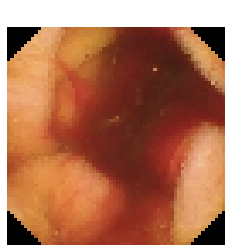

In [39]:
def show_image(img):
    for image, label in img:
        plt.figure()
        plt.figure(frameon=False, facecolor='white')
        plt.title(class_names[label.numpy()][0], fontdict={'color':'white','size':20})
        plt.imshow(image.numpy())
        plt.axis('off')

show_image(labeled_ds.take(1))

## Training
See https://lambdalabs.com/blog/tensorflow-2-0-tutorial-01-image-classification-basics/

https://github.com/lambdal/TensorFlow2-tutorial/tree/master/01-basic-image-classification

Splitting into training, test and validation data

In [40]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

shuffled_ds = labeled_ds.shuffle(buffer_size=10000)

train_ds = shuffled_ds.take(train_size)
test_ds = shuffled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [41]:
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(shuffled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

Full dataset sample size:        37746
Train dataset sample size:       26422
Test dataset sample size:         5661
Validation dataset sample size:   5663


In [42]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    #ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training, test and validation dataset
train_ds = prepare_for_training(train_ds, cache="./cache/binary_train_ds.tfcache")
test_ds = prepare_for_training(test_ds, cache="./cache/binary_test_ds.tfcache")
val_ds = prepare_for_training(val_ds, cache="./cache/binary_val_ds.tfcache")

In [43]:
tf.random.set_seed(22)
#train_dataset = train_dataset.map(augmentation).map(preprocess).shuffle(NUM_TRAIN_SAMPLES).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)
#test_dataset = test_dataset.map(preprocess).batch(BS_PER_GPU * NUM_GPUS, drop_remainder=True)

input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
img_input = tf.keras.layers.Input(shape=input_shape)
opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

if NUM_GPUS == 1:
    model = resnet.resnet56(img_input=img_input, classes=NUM_CLASSES)
    model.compile(
              optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
else:
    mirrored_strategy = tf.distribute.MirroredStrategy()
    with mirrored_strategy.scope():
      model = resnet.resnet56(img_input=img_input, classes=NUM_CLASSES)
      model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])  

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_callback = tf.keras.callbacks.TensorBoard(
  log_dir=log_dir,
  update_freq='batch',
  histogram_freq=1)

lr_schedule_callback = LearningRateScheduler(schedule)
# add EarlyStopping?
# add ModelCheckpoint?

history = model.fit(
    train_ds,
    steps_per_epoch = train_size // BATCH_SIZE,
    epochs = NUM_EPOCHS,
    validation_data = test_ds,
    validation_steps = test_size // BATCH_SIZE,
    validation_freq = 1,
    callbacks = [tensorboard_callback, lr_schedule_callback]
    )

# Print record of loss and metric values during training
# print('\nhistory dict:', history.history)

Train for 206 steps, validate for 44 steps
Epoch 1/10
206/206 [==============================] - 178s 864ms/step - loss: 1.2082 - sparse_categorical_accuracy: 0.8820 - val_loss: 112.9856 - val_sparse_categorical_accuracy: 0.8782
Epoch 2/10
206/206 [==============================] - 33s 161ms/step - loss: 1.0009 - sparse_categorical_accuracy: 0.8994 - val_loss: 1.2526 - val_sparse_categorical_accuracy: 0.7869
Epoch 3/10
206/206 [==============================] - 33s 161ms/step - loss: 0.8621 - sparse_categorical_accuracy: 0.9153 - val_loss: 1.8014 - val_sparse_categorical_accuracy: 0.4986
Epoch 4/10
206/206 [==============================] - 33s 161ms/step - loss: 0.7489 - sparse_categorical_accuracy: 0.9276 - val_loss: 0.9794 - val_sparse_categorical_accuracy: 0.8123
Epoch 5/10
206/206 [==============================] - 33s 162ms/step - loss: 0.6607 - sparse_categorical_accuracy: 0.9326 - val_loss: 0.8019 - val_sparse_categorical_accuracy: 0.8635
Epoch 6/10
206/206 [===================

## Validate the results

`Tensorboard`

In [60]:
# Clear any logs from previous runs (move to .old instead?)
# !rm -rf ./logs/

In [65]:
# Start tensorboard
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [61]:
# !kill 20058

`Keras`
Save/load the model

In [44]:
model.save('models/binary_split_resnet_10epoch.h5')
# new_model = keras.models.load_model('model.h5')

In [45]:
result = model.evaluate(
            val_ds,
            steps = val_size // BATCH_SIZE
            )

print (result)
# for key, value in result.items():
#     print(key, ":", value)

44/44 [==============================] - 45s 1s/step - loss: 0.6558 - sparse_categorical_accuracy: 0.8944
[0.6558219993656332, 0.8943537]


## Predict new samples

0.9932542 Negative
0.0067457 Positive

True label: Negative
Predicted label: Negative


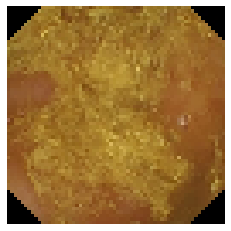

In [47]:
# Predict 1 image
image, label = next(iter(train_ds))
image = image.numpy()[0]
label = label.numpy()[0]

res = model.predict(np.expand_dims(image, axis=0))

count = 0
for number in res[0]:
    print("{:0.7f} {}".format(number,class_names[count]))
    count += 1
print()

print ("True label:", class_names[label[0]])
print ("Predicted label:", class_names[np.argmax(res[0])])

plt.figure()
plt.imshow(image)
plt.axis('off');

In [48]:
image, label = next(iter(train_ds))
image = image.numpy()
label = label.numpy()

results = model.predict(image)

idx = 0
for res in results:
    true_label = class_names[label[idx]][0]
    pred_label = class_names[np.argmax(res)]
    print ('{:3}  Label: {:20} Prediction: {}'.format(idx, true_label, pred_label))
    idx += 1

  0  Label: Negative             Prediction: Negative
  1  Label: Negative             Prediction: Negative
  2  Label: Negative             Prediction: Negative
  3  Label: Negative             Prediction: Negative
  4  Label: Negative             Prediction: Negative
  5  Label: Negative             Prediction: Negative
  6  Label: Negative             Prediction: Negative
  7  Label: Negative             Prediction: Negative
  8  Label: Negative             Prediction: Negative
  9  Label: Negative             Prediction: Negative
 10  Label: Negative             Prediction: Negative
 11  Label: Negative             Prediction: Negative
 12  Label: Negative             Prediction: Negative
 13  Label: Negative             Prediction: Negative
 14  Label: Negative             Prediction: Negative
 15  Label: Negative             Prediction: Negative
 16  Label: Negative             Prediction: Negative
 17  Label: Negative             Prediction: Negative
 18  Label: Positive        